# Set up 

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib.colors import ListedColormap
import seaborn as sns
import itertools
from itertools import combinations

import warnings

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score 
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor
from sklearn import neighbors, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import ShuffleSplit
from sklearn import linear_model
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

import xgboost as xgb
import lightgbm as lgb

np.random.seed(42)

# import data

In [2]:
df_dummy = pd.read_csv('C:/Users/14702/OneDrive/Desktop/Emory/Machine Learning II/Team Project/data_w_dummies.csv')

df_dummy.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_5to9,pdays_>10,pdays_never,poutcome_nonexistent,poutcome_success
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191,0,...,0,1,0,0,0,0,0,1,1,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191,0,...,0,1,0,0,0,0,0,1,1,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191,0,...,0,1,0,0,0,0,0,1,1,0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191,0,...,0,1,0,0,0,0,0,1,1,0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191,0,...,0,1,0,0,0,0,0,1,1,0


In [3]:
# data resampling to make positive : negative as 2:8

# get the distribution
count_0,count_1 = df_dummy.y.value_counts()

data_0 = df_dummy[df_dummy['y'] == 0]
data_1 = df_dummy[df_dummy['y'] == 1]

#Upsample data_1
data_1 = data_1.sample(int(count_1*2) ,replace=True, random_state=42)

# get the complete dataset
df = pd.concat([data_0 ,data_1] ,axis=0)

In [4]:
# retrieving Attributes
y = df.values[:,9]
X = df.drop(['y'],axis=1).values

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [5]:
# we want to use cross validation to tuning parameters
inner_cv = KFold(n_splits=5, shuffle=True,random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True,random_state=42)

In [6]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Function to calculate accuracy and plot confusion matrix 
def cal_accuracy(y_test, y_pred): 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix,classes=["1","0"],
                      title='Confusion matrix, without normalization')
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["1","0"], normalize=True,
                      title='Normalized confusion matrix')
    
    plt.show()

# XGBoost

In [21]:
########################################## XGBoost ##################################################

# Parameter tuning

param_test = {
 'max_depth':[2,3,4,5,6,7,8,9,10],
 'min_child_weight':[1,2,3,4,5,6,7,8,9,10],
 'learning_rate':[i/20.0 for i in range(0,10)]
}

gs_xgb = GridSearchCV(
    estimator = XGBClassifier(objective= 'binary:logistic',scale_pos_weight=1,seed=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv,
    n_jobs=-1)

gs_xgb = gs_xgb.fit(X_train,y_train)  
print("XGBoost Parameter Tuning")
print("Non-nested CV F1-score: ", gs_xgb.best_score_)
print("Optimal Parameter: ", gs_xgb.best_params_)
print("Optimal Estimator: ", gs_xgb.best_estimator_) 

XGBoost Parameter Tuning
Non-nested CV F1-score:  0.8508322374572527
Optimal Parameter:  {'learning_rate': 0.45, 'max_depth': 10, 'min_child_weight': 1}
Optimal Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.45,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=None, subsample=1,
       verbosity=1)


Accuracy :  94.67597643464978
Report :                precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      7342
         1.0       0.83      0.93      0.87      1824

   micro avg       0.95      0.95      0.95      9166
   macro avg       0.90      0.94      0.92      9166
weighted avg       0.95      0.95      0.95      9166

Confusion matrix, without normalization
[[6987  355]
 [ 133 1691]]
Normalized confusion matrix
[[0.95 0.05]
 [0.07 0.93]]


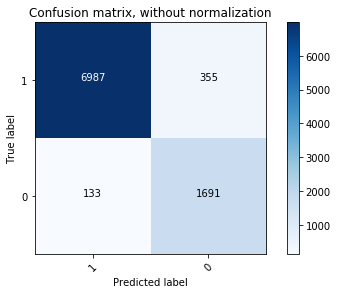

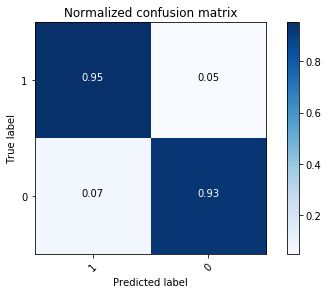

None


In [33]:
# XGBoost Classifier
clf_xgb = XGBClassifier(learning_rate = 0.45, max_depth = 10, min_child_weight = 1,
                        objective= 'binary:logistic',scale_pos_weight=1,seed=42)

# Make predictions 
clf_xgb = clf_xgb.fit(X_train, y_train) 
y_pred = clf_xgb.predict(X_test) 

# calculate accuracy and plot confusion matrix
print(cal_accuracy(y_test, y_pred))  

# LightGBM

In [12]:
########################################## LightGBM ##################################################

# Parameter tuning

param_test = {
 'max_depth':[4,5,6,7,8,9,10,11,12,13],
  'num_leaves':range(20, 170, 30),
 'learning_rate':[i/20.0 for i in range(1,10)]
}

gs_lgb = GridSearchCV(
    estimator = LGBMClassifier(scale_pos_weight=1,seed=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv)

gs_lgb = gs_lgb.fit(X_train,y_train)  
print("LightGBM Parameter Tuning")
print("Non-nested CV F1-score: ", gs_lgb.best_score_)
print("Optimal Parameter: ", gs_lgb.best_params_)
print("Optimal Estimator: ", gs_lgb.best_estimator_) 

LightGBM Parameter Tuning
Non-nested CV F1-score:  0.8530252081625661
Optimal Parameter:  {'learning_rate': 0.45, 'max_depth': 11, 'num_leaves': 140}
Optimal Estimator:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.45, max_depth=11,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=140, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=1, seed=42, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)


Accuracy :  94.41413921012438
Report :                precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      7342
         1.0       0.82      0.93      0.87      1824

   micro avg       0.94      0.94      0.94      9166
   macro avg       0.90      0.94      0.92      9166
weighted avg       0.95      0.94      0.95      9166

Confusion matrix, without normalization
[[6962  380]
 [ 132 1692]]
Normalized confusion matrix
[[0.95 0.05]
 [0.07 0.93]]


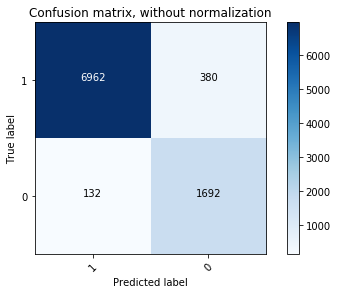

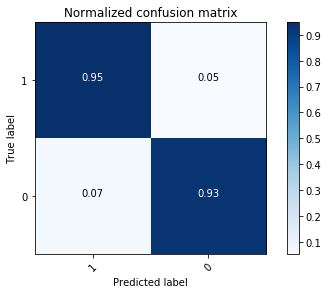

None


In [7]:
# LightGBM Classifier
clf_lgb = LGBMClassifier(learning_rate = 0.45, max_depth = 11, num_leaves = 140,
                        scale_pos_weight=1,seed=42)

# Make predictions 
clf_lgb = clf_lgb.fit(X_train, y_train) 
y_pred = clf_lgb.predict(X_test) 

# calculate accuracy and plot confusion matrix
print(cal_accuracy(y_test, y_pred))  

In [12]:
# variable importance
feat_labels = df.drop(['y'],axis=1).columns
importances = clf_lgb.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) duration                       2976.000000
 2) age                            2366.000000
 3) euribor3m                      1735.000000
 4) campaign                       900.000000
 5) cons.conf.idx                  428.000000
 6) cons.price.idx                 416.000000
 7) education_university.degree    265.000000
 8) housing_no                     258.000000
 9) job_admin.                     217.000000
10) housing_yes                    217.000000
11) day_of_week_thu                214.000000
12) education_high.school          214.000000
13) marital_married                209.000000
14) day_of_week_tue                187.000000
15) previous                       187.000000
16) day_of_week_mon                181.000000
17) day_of_week_wed                181.000000
18) marital_single                 154.000000
19) job_blue-collar                153.000000
20) contact_telephone              142.000000
21) emp.var.rate                   141.000000
22) education_professional.cour

In [17]:
# Parameter tuning LGBMRegressor

param_test = {
 'max_depth':[4,5,6,7,8,9,10,11,12,13],
  'num_leaves':range(20, 170, 30),
 'learning_rate':[i/20.0 for i in range(1,10)]
}

gs_lgbr = GridSearchCV(
    estimator = lgb.LGBMRegressor(objective='regression',metric='rmse', scale_pos_weight=1,seed=42), 
    param_grid = param_test, 
    scoring='neg_mean_squared_error',
    cv=inner_cv)

gs_lgbr = gs_lgbr.fit(X_train,y_train)  
print("LGBM Regressor Parameter Tuning")
print("Non-nested CV Negetive MSE: ", gs_lgbr.best_score_)
print("Optimal Parameter: ", gs_lgbr.best_params_)
print("Optimal Estimator: ", gs_lgbr.best_estimator_) 


LGBM Regressor Parameter Tuning
Non-nested CV F1-score:  -0.05306739796298465
Optimal Parameter:  {'learning_rate': 0.25, 'max_depth': 13, 'num_leaves': 140}
Optimal Estimator:  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.25, max_depth=13,
       metric='rmse', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=140,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, scale_pos_weight=1, seed=42, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [19]:
lgbr = lgb.LGBMRegressor(objective='regression',metric='rmse',learning_rate = 0.25, max_depth = 13, num_leaves = 140,
                        scale_pos_weight=1,seed=42)

lgbr = lgbr.fit(X_train,y_train)
y_pred = lgbr.predict(X_test) 

In [25]:
print('LGBM Regressor RMSE: ',round(np.sqrt(mean_squared_error(y_test, y_pred)),3))

"LGBM Regressor RMSE:  0.222


# ROC AUC

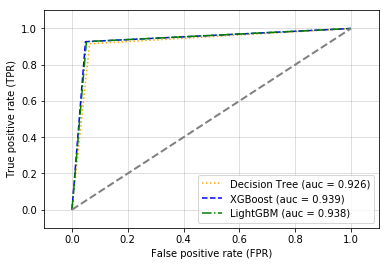

In [38]:
# Decision Tree Classifier
clf_dt = DecisionTreeClassifier(random_state=42)

# XGBoost Classifier
clf_xgb = XGBClassifier(learning_rate = 0.45, max_depth = 10, min_child_weight = 1,
                        objective= 'binary:logistic',scale_pos_weight=1,seed=42)
# LightGBM Classifier
clf_lgb = LGBMClassifier(learning_rate = 0.45, max_depth = 11, num_leaves = 140,
                        scale_pos_weight=1,seed=42)

# Label the classifiers
clf_labels = ['Decision Tree', 'XGBoost', 'LightGBM']
all_clf = [clf_dt, clf_xgb, clf_lgb]

# visualization   
colors = [ 'orange', 'blue', 'green']      # Colors for visualization
linestyles = [':', '--', '-.', '-']        # Line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):

    # Assuming the label of the positive class is 1 and data is normalized
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test) 
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.3f)' % (label, roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()